# Nature Conservancy Fish Classification - Bounding Box Regressor

### Imports & environment

In [1]:
import os
import ujson as json
import PIL

from keras.callbacks import ModelCheckpoint
from keras.layers import GlobalAveragePooling2D, Activation, Input, Flatten
from keras.models import Sequential

from utils import * 
from vgg16bn import Vgg16BN

ROOT_DIR = os.getcwd()
DATA_HOME_DIR = ROOT_DIR + '/data'
%matplotlib inline

Using TensorFlow backend.


### Config & Hyperparameters

In [2]:
# paths
data_path = DATA_HOME_DIR + '/' 
split_train_path = data_path + 'train/'
full_train_path = data_path + 'train_full/'
valid_path = data_path + 'valid/'
test_path = DATA_HOME_DIR + '/test'

# data
batch_size = 8
nb_split_train_samples = 3277
nb_full_train_samples = 3785
nb_valid_samples = 500
nb_test_samples = 1000
classes = ["ALB", "BET", "DOL", "LAG", "NoF", "OTHER", "SHARK", "YFT"]
nb_classes = len(classes)

# model
nb_epoch = 5
n_filters = 128
lr = 1e-2

In [3]:
test_path

'/home/ipl/Downloads/0126/train/nc-fish-classification/nc_fish_classification/data/test'

### Utils

In [4]:
def get_classes(trn_path, val_path, test_path):
    batches = get_batches(trn_path, shuffle=False, batch_size=1, target_size=(270, 480))
    val_batches = get_batches(val_path, shuffle=False, batch_size=1, target_size=(270, 480))
    test_batches = get_batches(test_path, shuffle=False, batch_size=1, target_size=(270, 480))
    return (val_batches.classes, batches.classes, onehot(val_batches.classes), onehot(batches.classes),
        val_batches.filenames, batches.filenames, test_batches.filenames)

In [5]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(split_train_path, valid_path, test_path)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


In [6]:
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

### Building Model and Saving/Loading Precomputed Conv Features

In [7]:
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop()
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

In [23]:
batches = get_batches(split_train_path, batch_size=1, target_size=(360, 640), shuffle=False,
                      class_mode=None)
conv_trn_feat = vgg640.predict_generator(batches, nb_split_train_samples)
save_array(data_path + 'precomputed/trn_ft_640.dat', conv_trn_feat)

del conv_trn_feat

Found 3277 images belonging to 8 classes.


KeyboardInterrupt: 

In [9]:
val_batches = get_batches(valid_path, batch_size=1, target_size=(360, 640), shuffle=False,
                          class_mode=None)
conv_val_feat = vgg640.predict_generator(val_batches, nb_valid_samples)
save_array(data_path + 'precomputed/val_ft_640.dat', conv_val_feat)

del conv_val_feat

Found 500 images belonging to 8 classes.


In [10]:
test_batches = get_batches(test_path, batch_size=1, target_size=(360, 640), shuffle=False,
                           class_mode=None)
conv_test_feat = vgg640.predict_generator(test_batches, nb_test_samples)
save_array(data_path+'precomputed/test_ft_640.dat', conv_test_feat)

del conv_test_feat

Found 1000 images belonging to 1 classes.


In [8]:
conv_val_feat = load_array(data_path + 'precomputed/val_ft_640.dat')
conv_trn_feat = load_array(data_path + 'precomputed/trn_ft_640.dat')
conv_test_feat = load_array(data_path + 'precomputed/test_ft_640.dat')

Sample images for visualizing model results (from validation set):

In [9]:
smp = get_data(valid_path, target_size=(360, 640))

Found 500 images belonging to 8 classes.


### Bounding Box Loading and Application

In [10]:
a=5

In [11]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']
bb_json = {}
for c in anno_classes:
    j = json.load(open('bb_annotations/{}.json'.format(c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]
            

bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

In [12]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

In [55]:
# f = open("val.txt","wb")
# print(raw_val_filenames, file=f)

with open("val.txt", 'w') as f:
    for s in raw_val_filenames:
        f.write(s + '\n')


In [58]:

with open("trn.txt", 'w') as f:
    for s in raw_filenames:
        f.write(s + '\n')


In [59]:
with open("test.txt", 'w') as f:
    for s in raw_test_filenames:
        f.write(s + '\n')
        

In [53]:
raw_val_filenames

['img_04783.jpg',
 'img_01928.jpg',
 'img_03202.jpg',
 'img_00039.jpg',
 'img_05154.jpg',
 'img_02382.jpg',
 'img_03800.jpg',
 'img_07763.jpg',
 'img_00756.jpg',
 'img_05214.jpg',
 'img_00993.jpg',
 'img_05193.jpg',
 'img_00396.jpg',
 'img_03775.jpg',
 'img_06693.jpg',
 'img_04124.jpg',
 'img_07636.jpg',
 'img_03682.jpg',
 'img_02946.jpg',
 'img_06383.jpg',
 'img_01121.jpg',
 'img_04874.jpg',
 'img_00201.jpg',
 'img_00337.jpg',
 'img_06995.jpg',
 'img_02163.jpg',
 'img_06865.jpg',
 'img_07225.jpg',
 'img_01822.jpg',
 'img_04861.jpg',
 'img_07701.jpg',
 'img_02036.jpg',
 'img_05040.jpg',
 'img_07126.jpg',
 'img_05227.jpg',
 'img_02774.jpg',
 'img_02489.jpg',
 'img_02148.jpg',
 'img_01985.jpg',
 'img_04059.jpg',
 'img_04025.jpg',
 'img_01786.jpg',
 'img_02047.jpg',
 'img_05017.jpg',
 'img_04196.jpg',
 'img_00015.jpg',
 'img_03067.jpg',
 'img_01990.jpg',
 'img_01507.jpg',
 'img_04713.jpg',
 'img_05570.jpg',
 'img_00713.jpg',
 'img_01247.jpg',
 'img_04981.jpg',
 'img_01744.jpg',
 'img_0403


For images with no annotations, just use an empty bounding box:


In [13]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [14]:
for f in raw_filenames:
    if not f in bb_json.keys():
        bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys():
        bb_json[f] = empty_bbox

Convert coordinate to resized 640x360 images:

In [15]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (640. / size[0])
    conv_y = (360. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [16]:
filenames[3000:3100]

['YFT/img_03196.jpg',
 'YFT/img_02411.jpg',
 'YFT/img_01861.jpg',
 'YFT/img_03127.jpg',
 'YFT/img_07595.jpg',
 'YFT/img_04077.jpg',
 'YFT/img_05066.jpg',
 'YFT/img_06920.jpg',
 'YFT/img_02727.jpg',
 'YFT/img_07742.jpg',
 'YFT/img_07901.jpg',
 'YFT/img_05477.jpg',
 'YFT/img_02220.jpg',
 'YFT/img_03266.jpg',
 'YFT/img_00214.jpg',
 'YFT/img_01634.jpg',
 'YFT/img_07752.jpg',
 'YFT/img_07166.jpg',
 'YFT/img_00752.jpg',
 'YFT/img_02713.jpg',
 'YFT/img_01370.jpg',
 'YFT/img_05183.jpg',
 'YFT/img_00871.jpg',
 'YFT/img_00420.jpg',
 'YFT/img_02219.jpg',
 'YFT/img_06819.jpg',
 'YFT/img_00069.jpg',
 'YFT/img_00093.jpg',
 'YFT/img_01469.jpg',
 'YFT/img_01700.jpg',
 'YFT/img_02626.jpg',
 'YFT/img_02917.jpg',
 'YFT/img_03824.jpg',
 'YFT/img_02597.jpg',
 'YFT/img_04768.jpg',
 'YFT/img_04756.jpg',
 'YFT/img_07510.jpg',
 'YFT/img_06418.jpg',
 'YFT/img_02038.jpg',
 'YFT/img_01817.jpg',
 'YFT/img_07602.jpg',
 'YFT/img_02274.jpg',
 'YFT/img_02149.jpg',
 'YFT/img_00815.jpg',
 'YFT/img_06094.jpg',
 'YFT/img_

In [17]:
trn_sizes = [PIL.Image.open(full_train_path + f).size for f in filenames]
val_sizes = [PIL.Image.open(valid_path + f).size for f in val_filenames]

In [18]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f, s in zip(raw_filenames, trn_sizes)]).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) for f, s in zip(raw_val_filenames, val_sizes)]).astype(np.float32)

Visualize result:

In [19]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_bbox[i]
    plot(smp[i])
    plt.gca().add_patch(create_rect(bb))

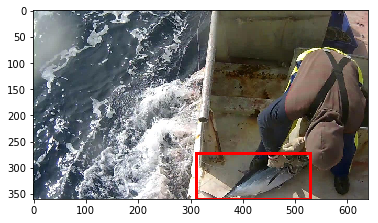

In [20]:
show_bb(0)

### Train the BB Regressor

In [21]:
conv_layers, _ = split_at(vgg640, Convolution2D)
input_shape = conv_layers[-1].output_shape[1:]

del vgg640; del conv_layers

In [22]:
model = Sequential()

model.add(MaxPooling2D(input_shape=input_shape))
model.add(BatchNormalization(axis=1))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(4))

model.compile(Adam(lr=0.001), loss='mse')

In [23]:
conv_trn_feat.shape

(3277, 512, 22, 40)

In [27]:
# model.fit(conv_trn_feat, trn_bbox,
#           batch_size=batch_size,
#           nb_epoch=3,
#           verbose=2,
#           validation_data=(conv_val_feat, val_bbox))

In [28]:
# model.optimizer.lr = 1e-7
# ckpt = ModelCheckpoint('models/bb_regressor/360x640/loss-{val_loss:.2f}_vgg16_bn.h5', monitor='val_loss',
#                        verbose=0, save_best_only=True, save_weights_only=True)

# model.fit(conv_trn_feat, trn_bbox,
#           batch_size=batch_size,
#           nb_epoch=10,
#           verbose=1,
#           validation_data=(conv_val_feat, val_bbox),
#           callbacks=[ckpt])

In [24]:
#model.load_weights('models/bb_regressor/360x640/loss-1103.20_vgg16_bn.h5')  # current best
#model.load_weights('models/bb_regressor/360x640/loss-1248.00_vgg16_bn.h5')  # current best
model.load_weights('models/bb_regressor/360x640/loss-1248.00_vgg16_bn.h5')  # current best


In [32]:
pred = model.predict(conv_val_feat[:200]) 

In [56]:
pred = model.predict(conv_trn_feat[:]) 

In [47]:
pred = model.predict(conv_val_feat[:]) 

In [60]:
pred = model.predict(conv_test_feat[:]) 

In [51]:
pred[0]
#pred.shape

array([  89.3271,  214.8219,  328.3407,  276.4174], dtype=float32)

In [61]:
np.savetxt("test.csv", pred, delimiter=",")

In [42]:
#pred

Visualize predictions on sample images:

In [43]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[i]
    plt.figure(figsize=(6,6))
    plot(smp[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

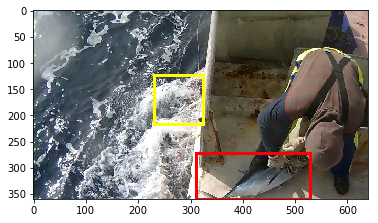

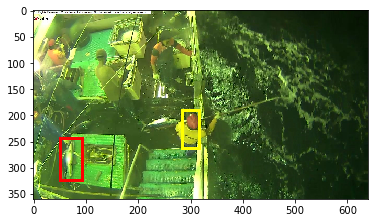

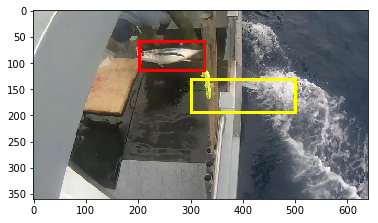

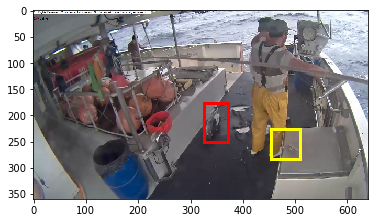

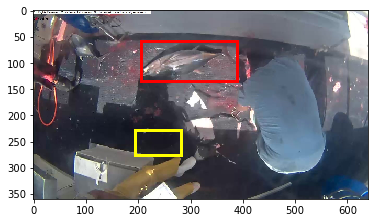

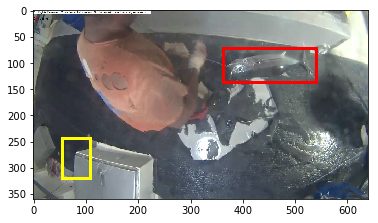

In [44]:
show_bb_pred(0)
show_bb_pred(1)
show_bb_pred(3)
show_bb_pred(4)
show_bb_pred(5)
show_bb_pred(6)
# show_bb_pred(57)
# show_bb_pred(58)
# show_bb_pred(59)
# show_bb_pred(60)
# show_bb_pred(61)
# show_bb_pred(62)
# show_bb_pred(63)
# show_bb_pred(120)
# show_bb_pred(122)
# show_bb_pred(125)
# show_bb_pred(129)
# show_bb_pred(158)
# show_bb_pred(193)
# show_bb_pred(88)
# show_bb_pred(94)
# show_bb_pred(95)
# show_bb_pred(96)
# show_bb_pred(97)
# show_bb_pred(98)
# show_bb_pred(99)
# show_bb_pred(100)